### Overview
Author: Denizhan Akar

In this work, we wanted to investigate the usefulness/misleadingness of direct logit attribution (DLA), a mechanistic interpretability technique for interpreting the residual stream across the transformer by applying the unembedding matrix to project to logit space, and demonstrate the existence of other methods that are better at interpreting the residual stream in some capacity over DLA. We do this by:
- Extending the original logit lens investigation to include "extended" unembeddings that incorporate layers at the end of the model;
- Applying our investigation to not only GPT-2 and GPT-Neo, which tie their embedding and unembedding matrices, but also to GPT-NeoX which _doesn't_ tie it's (un)embedding matrices via `pythia`, thus opening up opportunities to also investigate the interpretability of "lens" techniques across training checkpoints;
- Investigating the original and extended logit lens on the IOI task, thus giving us the ability to use the _logit difference_ as a way to reasonably compare between models;
- Using the [TransformerLens](https://github.com/neelnanda-io/TransformerLens) library to conduct the analysis in clearer code (thanks to functions such as `run_with_cache`)
- Making it easy to extend the lens in other ways in future work.

From our investigation we find that:
- when we don't fix the LayerNorm scale to prevent non-linearity, we can obtain logit difference results that are three times as much compared to when it is fixed;
- there is a weak tendency for GPT-NeoX and strong tendency for GPT-Neo to assign a lower probability to the output it will output at the end of the model midway through the transformer;
- GPT-Neo, when extending the unembedding only to the last layer's MLP, strongly tends to assign a higher probability (relative to other after-block residuals) to the output that it will output in the end when the unembedding is applied right after the first transformer block;
- Adding further layers to the unembedding makes the model _much_ more likely to assign higher probabilities to the output it wants to output throughout the residual stream _if the model appears impossible to interpret from the unembedding matrix alone_, otherwise it doesn't change the residual stream wants-to-output-token probability by much.

### Constants

In [2]:
def check_colab():
    # Check if we're in Colab
    from importlib.util import find_spec
    IN_COLAB = True if find_spec('google.colab') else False
    print(f"Running as Colab: {IN_COLAB}")
CHECK_EMBED_UNEMBED = False
NEW_CONDA_ENV = False
IN_COLAB = check_colab()

Running as Colab: False


### Import, no autodiff to save GPU memory (want infer no train)

In [3]:
"""conda/pip install dependencies
%conda install -n mechinterp ipykernel --update-deps --force-reinstall
%pip install ipywidgets
%conda install pytorch pytorch-cuda=11.6 -c pytorch -c nvidia
%conda install datasets
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

# Install another version of node that makes PySvelte work way faster (not necessary)
!curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs

%pip install git+https://github.com/neelnanda-io/PySvelte.git
%pip install kaleido
%pip install nbformat
%pip install requests
%pip install PyYAML
%pip install plotly
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader
from torchtyping import TensorType as TT
from typing import List, Tuple, Union, Optional
from functools import partial
import copy
import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
import pysvelte
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import plotly.io as pio
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
pio.renderers.default = "colab" if IN_COLAB else "png"
print(f"CUDA is available: {torch.cuda.is_available()}")
assert torch.cuda.is_available()
torch.set_grad_enabled(False)

CUDA is available: True


### Plotting helper functions

In [4]:
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

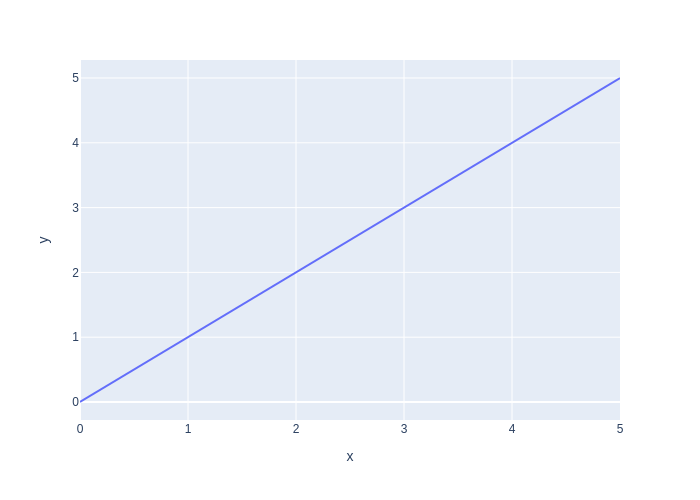

In [5]:
# Test function
line(np.arange(6))

### Load `gpt2-small`

In [6]:
# model = HookedTransformer.from_pretrained(
#     "gpt2-small",
#     center_unembed=apply_operation, # was True
#     center_writing_weights=apply_operation, # was True
#     fold_ln=apply_operation, # was True
#     refactor_factored_attn_matrices=True,)

def load_model(
    model_name: str = "gpt2-small",
    check_embed_unembed: bool = False,
    ):
    apply_operation = not check_embed_unembed
    model = HookedTransformer.from_pretrained(
        model_name,
        center_unembed=apply_operation, # was True
        center_writing_weights=False, # was True
        fold_ln=apply_operation, # was True
        refactor_factored_attn_matrices=False,)
    return model

model = load_model(
    model_name="gpt2-small",
    check_embed_unembed=CHECK_EMBED_UNEMBED,
)

if CHECK_EMBED_UNEMBED:
    print(f"(model.embed.W_E == model.unembed.W_U.T) == {(model.embed.W_E == model.unembed.W_U.T).all()}")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


### Run prompt to check model working correctly

In [7]:
def test_prompt(model: HookedTransformer = model):
    example_prompt = "After John and Mary went to the store, John gave a bottle of milk to"
    example_answer = " Mary"
    utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)
test_prompt()

Tokenized prompt: ['<|endoftext|>', 'After', ' John', ' and', ' Mary', ' went', ' to', ' the', ' store', ',', ' John', ' gave', ' a', ' bottle', ' of', ' milk', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 18.09 Prob: 70.07% Token: | Mary|

Top 0th token. Logit: 18.09 Prob: 70.07% Token: | Mary|
Top 1th token. Logit: 15.38 Prob:  4.67% Token: | the|
Top 2th token. Logit: 15.35 Prob:  4.54% Token: | John|
Top 3th token. Logit: 15.25 Prob:  4.11% Token: | them|
Top 4th token. Logit: 14.84 Prob:  2.73% Token: | his|
Top 5th token. Logit: 14.06 Prob:  1.24% Token: | her|
Top 6th token. Logit: 13.54 Prob:  0.74% Token: | a|
Top 7th token. Logit: 13.52 Prob:  0.73% Token: | their|
Top 8th token. Logit: 13.13 Prob:  0.49% Token: | Jesus|
Top 9th token. Logit: 12.97 Prob:  0.42% Token: | him|


Ranks of the answer tokens: [(' Mary', 0)]

### Load in IOI `prompts` and `answer_pairs`

In [8]:
def get_prompt_answer_tokens(model: HookedTransformer = model):
    prompt_format = ["When John and Mary went to the shops,{} gave the bag to",
                    "When Tom and James went to the park,{} gave the ball to",
                    "When Dan and Sid went to the shops,{} gave an apple to",
                    "After Martin and Amy went to the park,{} gave a drink to",]
    names = [(" Mary", " John"),
            (" Tom", " James"),
            (" Dan", " Sid"),
            (" Martin", " Amy"),]
    
    # number of prompt formats
    n_prompt_formats = len(prompt_format); assert n_prompt_formats == len(names)
    
    # List of prompts
    prompts = []
    # List of answers, in the format (correct, incorrect)
    answer_pairs = []
    # List of the token (ie an integer) corresponding to each answer, in the format (correct_token, incorrect_token)
    answer_tokens = []

    for i_prompt in range(len(prompt_format)):
        for j_order in range(2):
            answer_pairs.append((names[i_prompt][j_order], names[i_prompt][1 - j_order]))
            answer_tokens.append(
                (
                    model.to_single_token(answer_pairs[-1][0]),
                    model.to_single_token(answer_pairs[-1][1]),
                )
            )
            # Insert the *incorrect* answer to the prompt, making the correct answer the indirect object.
            prompts.append(prompt_format[i_prompt].format(answer_pairs[-1][1]))
    # Move tokens to GPU
    answer_tokens = torch.tensor(answer_tokens).cuda()
    prompt_tokens = model.to_tokens(prompts, prepend_bos=True).cuda()

    # Check no prompts are truncated i.e. all prompts have the same number of tokens.
    assert not (prompt_tokens[:, -1] == model.to_single_token(model.tokenizer.bos_token)).any()
    return prompts, prompt_tokens, answer_pairs, answer_tokens

prompts, prompt_tokens, answer_pairs, answer_tokens = get_prompt_answer_tokens(model)
n_batches = len(prompts); assert n_batches == len(answer_pairs) # number of batches
n_positions = prompt_tokens.shape[1] # number of positions
d_vocab = model.cfg.d_vocab # dimensions of vocabulary
# prompts:                  List[str];              len(prompts) == n_batches
# prompt_tokens:            torch.Tensor.cuda;      shape == (n_batches, n_positions)
# answer_pairs:             List[Tuple[str, str]]]; shape == (n_batches, 2)
# answer_tokens:            torch.Tensor.cuda;      shape == (n_batches, 2)
# model.to_str_tokens(prompts[0]) == ['<|endoftext|>', 'When', ' John', ' and', ..., ' to']
# len(model.to_str_tokens(prompts[0])) == n_positions

### `run_with_cache` to get `clean_cache_final_logits` and `cache`, use `avg_logit_diff_of_last_pos`

In [9]:
# We now run the model on these prompts and use `run_with_cache` to get both the logits and a cache of all internal activations for later analysis

# Run model and store logits for every batch and position in `clean_cache_final_logits`
# Store activations for every batch, position, and hook in `cache`
clean_cache_final_logits, cache = model.run_with_cache(prompt_tokens)
# clean_cache_final_logits:  torch.Tensor.cuda;      shape == (n_batches, n_positions, d_vocab)
# cache.__dict__.keys() == dict_keys(['cache_dict', 'model', 'has_batch_dim', 'has_embed', 'has_pos_embed'])

def avg_logit_diff_of_last_pos(logits, answer_tokens, per_prompt=False):
    """
    Get logits for last position, use answer_tokens to get index of correct and incorrect answer index in d_vocab, and either return the difference per prompt or return the average difference over all prompts.
    """
    # Only the final logits are relevant for the answer
    final_pos_logits = logits[:, -1, :]
    answer_logits = final_pos_logits.gather(dim=-1, index=answer_tokens)
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()

clean_cache_per_prompt_last_pos_logit_diff = avg_logit_diff_of_last_pos(clean_cache_final_logits, answer_tokens, per_prompt=True)

clean_cache_avg_last_pos_logit_diff = avg_logit_diff_of_last_pos(clean_cache_final_logits, answer_tokens).item()

print("Per prompt logit difference:", clean_cache_per_prompt_last_pos_logit_diff)
print("Average logit difference:", clean_cache_avg_last_pos_logit_diff)

Per prompt logit difference: tensor([3.3367, 3.2016, 2.7095, 3.7975, 1.7204, 5.2812, 2.6008, 5.7674],
       device='cuda:0')
Average logit difference: 3.551889419555664


### Get directions in the residual stream of the answer tokens

In [10]:

# Having already folded LayerNorm, gives us the direction within the residual stream for
# the answer tokens before the unembedding (but after LayerNormPre was applied).
# [prompt_count, 2, d_model]
answer_bef_unembed_residual_directions = model.tokens_to_residual_directions(answer_tokens)
print("Answer residual directions shape:", answer_bef_unembed_residual_directions.shape)

# Get the logit differences (row vectors) between the correct vs good incorrect answers.
# [prompt_count, d_model]
logit_diff_directions = answer_bef_unembed_residual_directions[:, 0] - answer_bef_unembed_residual_directions[:, 1]
print("Logit difference directions shape:", logit_diff_directions.shape)

Answer residual directions shape: torch.Size([8, 2, 768])
Logit difference directions shape: torch.Size([8, 768])


### Playing with `cache`

In [11]:
# cache["hook_embed"].shape == (n_batches, n_positions, d_hook)

# Recall that our weights in the model are already frozen, so the hooks in the model aren't for them.
# The hooks are for each time we had sent through the input, the resulting activations right after (or before
# if `pre`) applying the model layer/operation.
print(cache["hook_embed"].shape)
# print(cache)

# `cache["hook_embed"][0]` is the model activation in the residual stream after embedding the prompt tokens when we send through the first prompt. `cache["hook_embed"][2]` is the third prompt
(cache["hook_embed"][0] == cache["hook_embed"][2])
# print(cache["hook_embed"][0][10][0])
# print(cache["hook_embed"][1][10][0])

cache["blocks.0.hook_resid_pre"][0]

# (cache["hook_embed"][0][0] + cache["hook_pos_embed"][0][0] == cache["blocks.0.hook_resid_pre"][0][0])

# cache["hook_embed"][-1].shape
# model.embed.W_E

torch.Size([8, 15, 768])


tensor([[ 0.0325, -0.2251,  0.0540,  ..., -0.0360,  0.1835,  0.1752],
        [ 0.0361, -0.0951, -0.0666,  ...,  0.2121, -0.0547, -0.0123],
        [ 0.0268, -0.0846,  0.2619,  ...,  0.0473,  0.0790, -0.1047],
        ...,
        [-0.0392,  0.0222,  0.1391,  ..., -0.0493,  0.0661, -0.0549],
        [ 0.1464,  0.0469,  0.1503,  ...,  0.0531,  0.0512,  0.2590],
        [-0.0079, -0.0792,  0.1266,  ..., -0.0162,  0.0958,  0.0774]],
       device='cuda:0')

### `Slices`

In [12]:
from easy_transformer.utils import Slice

# [prompt_count, prompt_pos, d_model]
cache["hook_embed"].shape

# [prompt_count, prompt_pos, 1]
cache["ln_final.hook_scale"].shape

# pos_slice = Get last position 
# [prompt_count, 1]
# scale = pos_slice.apply(scale, dim=-2)
scale = Slice(-1).apply(cache["ln_final.hook_scale"], dim=-2)
scale == cache["ln_final.hook_scale"][:, -1, :]

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

### Get residual stream

In [13]:
# cache syntax: resid_post is the residual stream at the last position, -1 gets the final layer.
# The general syntax is [activation_name, pos_index, sub_layer_type]. 
# Specifically, here for gpt2-small we would get blocks.11.hook_resid_post.
# [prompt_count, prompt_pos, d_model]
final_residual_stream = cache["resid_post", -1]
print("Final residual stream shape:", final_residual_stream.shape)

# Get the final position's representation in the residual stream.
# [prompt_count, d_model]
final_token_residual_stream = final_residual_stream[:, -1, :]

# Apply LayerNorm scaling
# pos_slice is the subset of the positions we take - here the final token of each prompt

# `apply_ln_to_stack` takes a stack of components of the residual stream, centers last dimension,
# treats them as the input to a specific ln layer, and applies the layer norm scaling of that layer to them,
# using the cached scale factors - simulating what that component of the residual stream contributes to that layer's input.
# TLDR: mean and scale (with that layer's scale) to not have a new mean and scale 
# [prompt_count, d_model]
scaled_final_token_residual_stream = cache.apply_ln_to_stack(final_token_residual_stream, layer = -1, pos_slice=-1)

average_logit_diff = einsum(
    "batch d_model, batch d_model -> ",
    scaled_final_token_residual_stream,
    logit_diff_directions
).item() / len(prompts)

def print_check_if_basically_same(a, b, tol=1e-5):
    print(f"(abs({a} - {b}) < {tol}) == {abs(a - b) < tol}")

# They are the same because we have already folded LayerNorm into the weights and centered the unembed.
print("Calculated average logit diff:", average_logit_diff)
print("Original logit difference:", clean_cache_avg_last_pos_logit_diff)
print_check_if_basically_same(average_logit_diff, clean_cache_avg_last_pos_logit_diff)
assert abs(average_logit_diff - clean_cache_avg_last_pos_logit_diff) < 1e-5

Final residual stream shape: torch.Size([8, 15, 768])
Calculated average logit diff: 3.5518898963928223
Original logit difference: 3.551889419555664
(abs(3.5518898963928223 - 3.551889419555664) < 1e-05) == True


### Output logit difference via `def residual_stack_to_logit_diff`

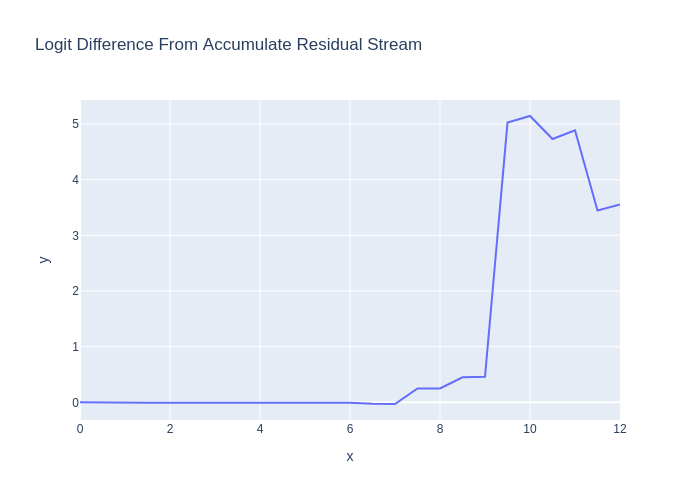

In [14]:
def residual_stack_to_logit_diff(residual_stack: TT["components", "batch", "d_model"],
                                 cache: ActivationCache,
                                 logit_diff_directions,
                                 prompts,
                                 ln_layer: int = -1,
                                 pos_slice: int = -1) -> float:
    """
    
    """
    # [residual_point_count, prompt_count, d_model]
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer=ln_layer, pos_slice=pos_slice)
    # Take average logit difference for every residual point across all prompts.
    # scaled
    # [residual_point_count]
    return einsum("... batch d_model, batch d_model -> ...", scaled_residual_stack, logit_diff_directions)/len(prompts)

# Get the residual stream up to a certain layer.
# Only has pre's (and mid if incl_mid) - no post's (unless set -1 or, if our layers are from 0 to n-1, set n)
# We get the pre in the residual stream of layer i for 0, ..., n-1 and also before unembed if i==n.
# If incl_mid, residual_point_count = n_layers*2 + 1, else residual_point_count = n_layers + 1.
# [residual_hook_count, n_batches, d_model], len(n_layers*2)
accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)

# [residual_point_count]
logit_lens_logit_diffs = residual_stack_to_logit_diff(
    accumulated_residual,
    cache,
    logit_diff_directions,
    prompts,
    ln_layer=-1,
    pos_slice=-1,
)

# x=np.arange(model.cfg.n_layers*2+1)/2
line(
    logit_lens_logit_diffs,
    x=np.arange(len(labels))/2 if "0_mid" in labels else np.arange(len(labels)),
    hover_name=labels,
    title="Logit Difference From Accumulate Residual Stream",
)



### Output with layers included for unembedding

In [15]:
# Get the residual stream up to a certain layer.
# Only has pre's (and mid if incl_mid) - no post's (unless set -1 or, if our layers are from 0 to n-1, set n)
# We get the pre in the residual stream of layer i for 0, ..., n-1 and also before unembed if i==n.
# If incl_mid, residual_point_count = n_layers*2 + 1, else residual_point_count = n_layers + 1.

# [residual_hook_count, n_batches, n_positions, d_model], len(n_layers*2)
accumulated_residual, labels = cache.accumulated_resid(layer=11, incl_mid=True, return_labels=True)

def copy_hook_in_run(from_layer, to_layer, model):
    """
    Copy paste hook from `from_layer` to `to_layer` in `cache` and run the rest in `model`.
    """
    # Copy paste hook from `from_layer` to `to_layer` in `cache`.
    cache[f"hook_{from_layer}"] = cache[f"hook_{to_layer}"]
    # Run the rest in `model`.
    return model.run(**cache)


# [residual_point_count]

# Run the corrupted run with the patch from clean run.
# patched_residual_stream_diff = torch.zeros(
#     model.cfg.n_layers, 
#     prompt_tokens.shape[1], 
#     device="cuda", 
#     dtype=torch.float32,
# )
# for layer in range(model.cfg.n_layers):
#     for position in range(prompt_tokens.shape[1]):
#         hook_fn = partial(patch_activation, pos=position, clean_cache=cache)
#         # Run everything as normal except force the activation at specified locations to
#         # be of the one that we introduce.
#         patched_logits = model.run_with_hooks(
#             corrupted_tokens, 
#             # get `resid_pre` hook of layer (e.g. `blocks.1.hook_resid_pre`) and replace them with our hook.
#             fwd_hooks = [(utils.get_act_name("resid_pre", layer), hook_fn)], 
#             return_type="logits")
        
#         # Get the average logit difference.
#         patched_logit_diff = avg_logit_diff_of_last_pos(patched_logits, answer_tokens)
#         patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(
#             patched_logit_diff,
#             corrupted_average_logit_diff,
#             clean_cache_avg_last_pos_logit_diff,
#         )



# logit_lens_logit_diffs = residual_stack_to_logit_diff(
#     accumulated_residual,
#     cache,
#     logit_diff_directions,
#     prompts,
#     ln_layer=-1,
#     pos_slice=-1,
# )

# # x=np.arange(model.cfg.n_layers*2+1)/2
# line(
#     logit_lens_logit_diffs,
#     x=np.arange(len(labels))/2 if "0_mid" in labels else np.arange(len(labels)),
#     hover_name=labels,
#     title="Logit Difference From Accumulate Residual Stream",
# )

### Activation patching

Clean prompt 0:     When John and Mary went to the shops, John gave the bag to
Corrupted prompt 0: When John and Mary went to the shops, Mary gave the bag to
Answer for 0:  Mary
Clean Average Logit Diff 3.551889419555664
Corrupted Average Logit Diff tensor(-3.5519, device='cuda:0')


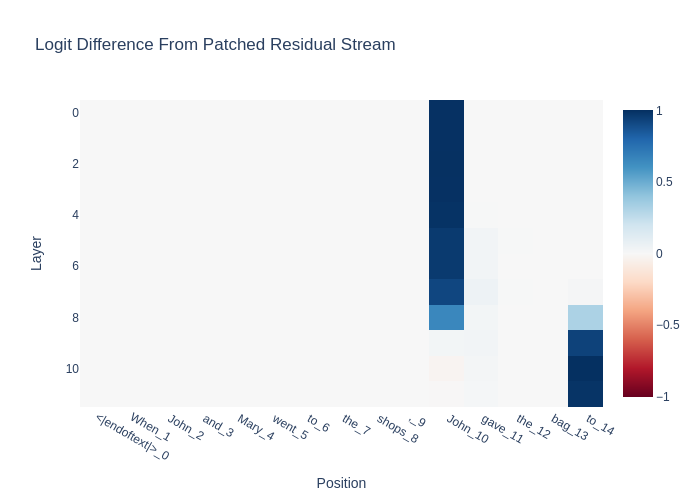

In [16]:

# Note that the corruptions stems from the prompt input being swapped for the answer input.
# Nothing else is corrupted.
# When we patch in, 

model.reset_hooks()

corrupted_prompts = []
for i in range(0, len(prompts), 2):
    corrupted_prompts.append(prompts[i+1])
    corrupted_prompts.append(prompts[i])
corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
corrupted_average_logit_diff = avg_logit_diff_of_last_pos(corrupted_logits, answer_tokens)

print("Clean prompt 0:    ", prompts[0])
print("Corrupted prompt 0:", corrupted_prompts[0])
print("Answer for 0:", answer_pairs[0][0])
print("Clean Average Logit Diff", clean_cache_avg_last_pos_logit_diff)
print("Corrupted Average Logit Diff", corrupted_average_logit_diff)

def patch_activation_of_specific_name_and_pos(
        corrupted_activation: TT["batch", "pos", "d_model"],
        hook,  # hook class object which is an nn.Module
        pos, 
        clean_cache):
    corrupted_activation[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_activation

def normalize_patched_logit_diff(
        patched_logit_diff,
        corrupted_average_logit_diff,
        clean_cache_avg_last_pos_logit_diff,):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise. 0 means zero change (the corrupted and patched logits at end of network are the same i.e. the network still wants to output the wrong answer with the same amount of probability), negative means made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_average_logit_diff)/(clean_cache_avg_last_pos_logit_diff - corrupted_average_logit_diff)

# Run the corrupted run with the patch from clean run.
# [layers, positions]
patched_residual_stream_diff = torch.zeros(
    model.cfg.n_layers, 
    prompt_tokens.shape[1], 
    device="cuda", 
    dtype=torch.float32,
)
for layer in range(model.cfg.n_layers):
    for position in range(prompt_tokens.shape[1]):
        hook_fn = partial(patch_activation_of_specific_name_and_pos, pos=position, clean_cache=cache)
        # Run everything as normal except force the activation at specified locations to
        # be of the one that we introduce.
        patched_logits = model.run_with_hooks(
            corrupted_tokens, 
            # get `resid_pre` hook of layer (e.g. `blocks.1.hook_resid_pre`) and replace them with our hook.
            fwd_hooks = [(utils.get_act_name("resid_pre", layer), hook_fn)], 
            return_type="logits")
        
        # Get the average logit difference.
        patched_logit_diff = avg_logit_diff_of_last_pos(patched_logits, answer_tokens)
        patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(
            patched_logit_diff,
            corrupted_average_logit_diff,
            clean_cache_avg_last_pos_logit_diff,
        )

prompt_position_labels = [f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(prompt_tokens[0]))]

imshow(
    patched_residual_stream_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Residual Stream",
    labels={"x":"Position", "y":"Layer"},
)


### Plot all logit attribution and extended logit lens

Clean prompt 0:     When John and Mary went to the shops, John gave the bag to
Corrupted prompt 0: When John and Mary went to the shops, Mary gave the bag to
Answer for 0:  Mary
Clean Average Logit Diff 3.551889419555664
Corrupted Average Logit Diff tensor(-3.5519, device='cuda:0')
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


Using pad_token, but it is not set yet.


Loaded pretrained model gpt-neo-125M into HookedTransformer


Using pad_token, but it is not set yet.


Loaded pretrained model pythia-125m into HookedTransformer
gpt2
decoder starts at blocks.11.hook_resid_post


/home/da537/.conda/envs/mechinterp/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




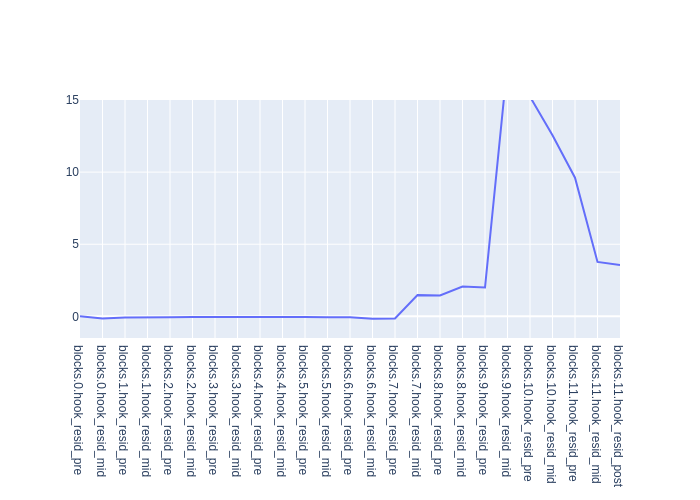

gpt2
decoder starts at blocks.11.hook_resid_mid


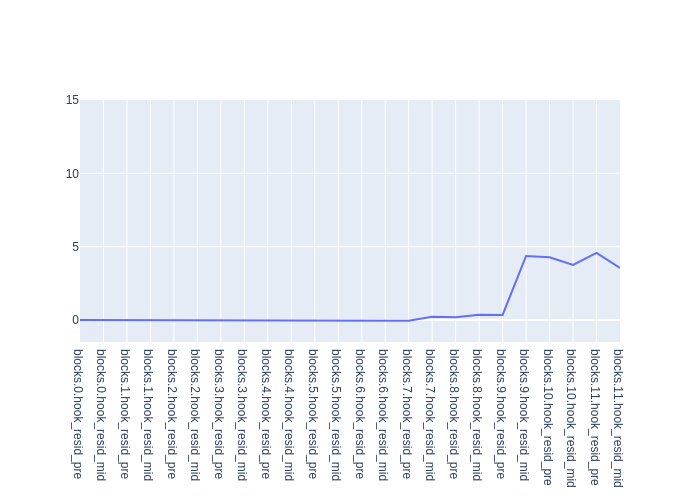

gpt2
decoder starts at blocks.11.hook_resid_pre


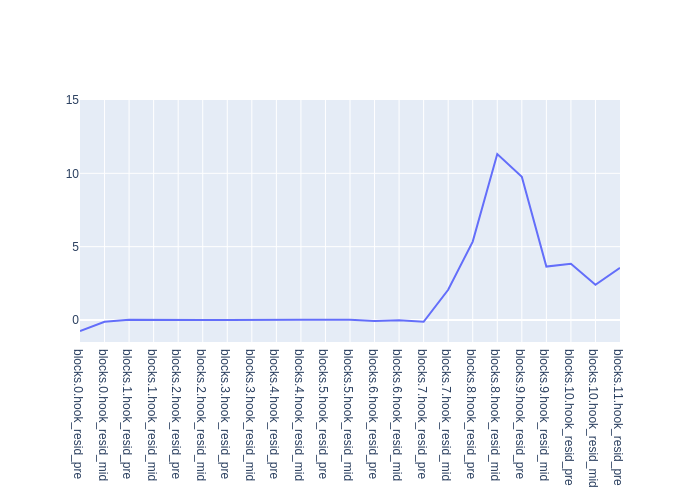

gpt2
decoder starts at blocks.10.hook_resid_pre


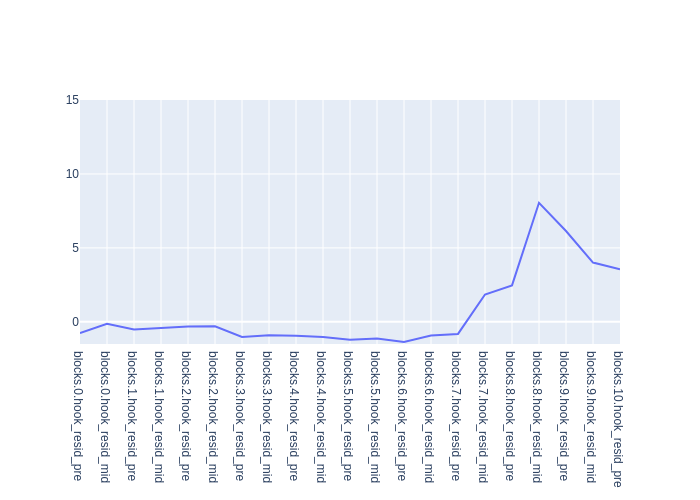

gpt2
decoder starts at blocks.9.hook_resid_pre


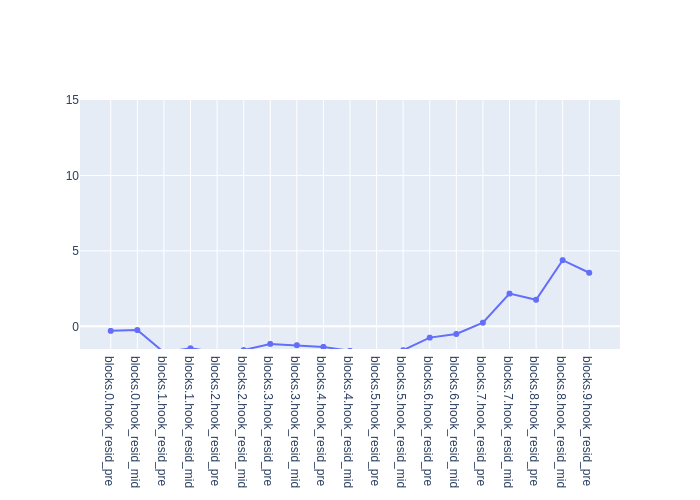

----------------------------------------------------------------------------------------------------
gpt-neo-125M
decoder starts at blocks.11.hook_resid_post


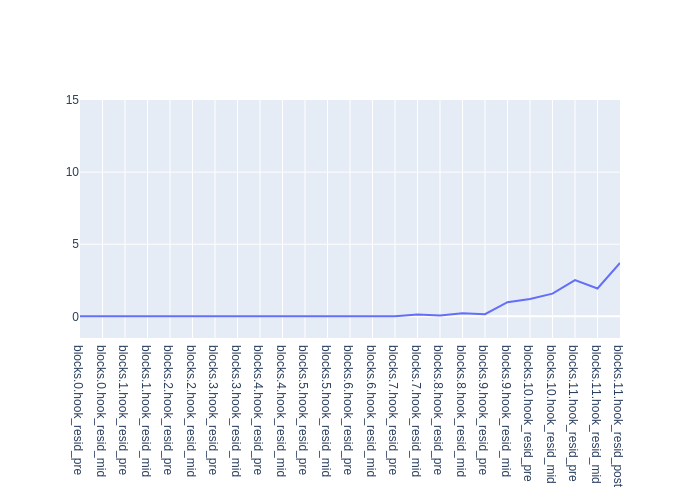

gpt-neo-125M
decoder starts at blocks.11.hook_resid_mid


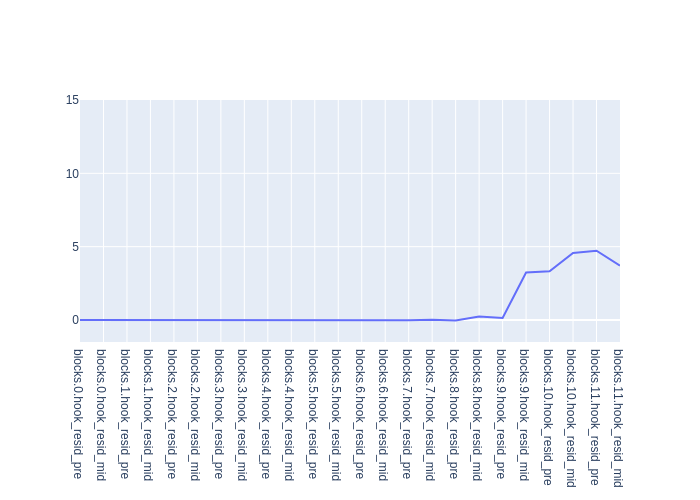

gpt-neo-125M
decoder starts at blocks.11.hook_resid_pre


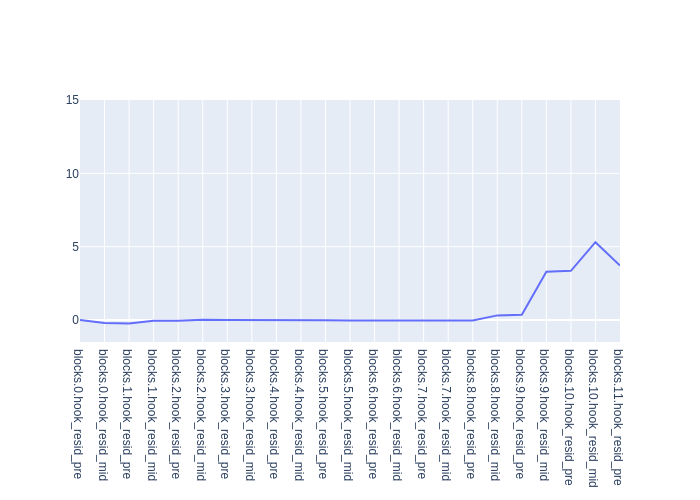

gpt-neo-125M
decoder starts at blocks.10.hook_resid_pre


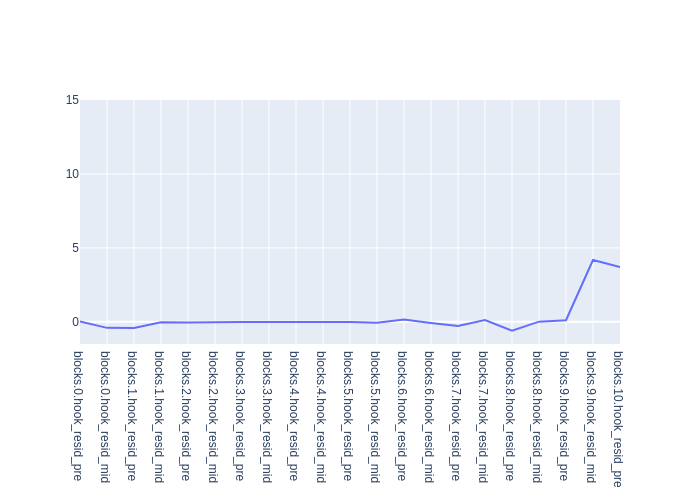

gpt-neo-125M
decoder starts at blocks.9.hook_resid_pre


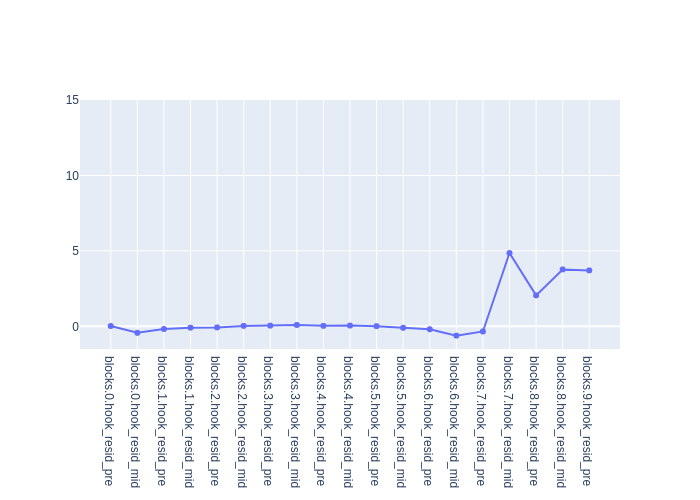

----------------------------------------------------------------------------------------------------
pythia-125m
decoder starts at blocks.11.hook_resid_post


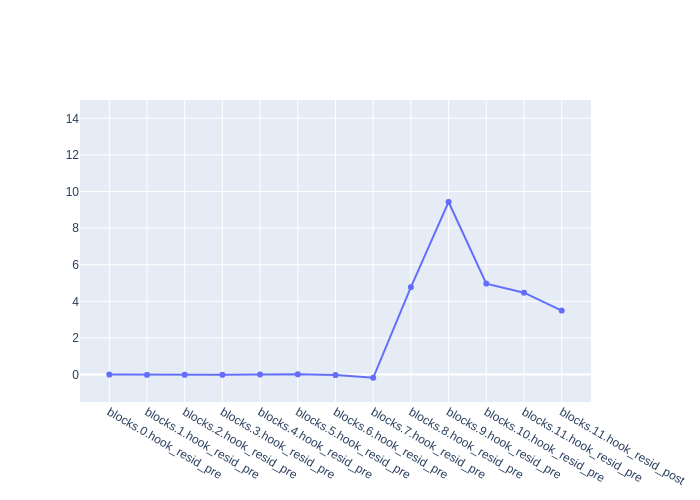

pythia-125m
decoder starts at blocks.11.hook_resid_pre


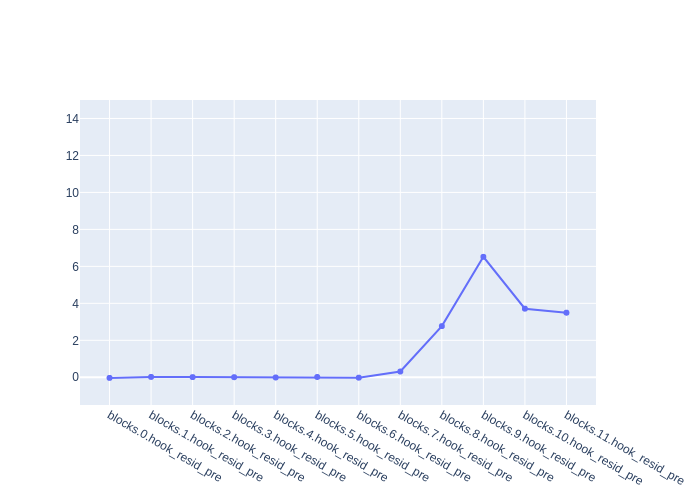

pythia-125m
decoder starts at blocks.10.hook_resid_pre


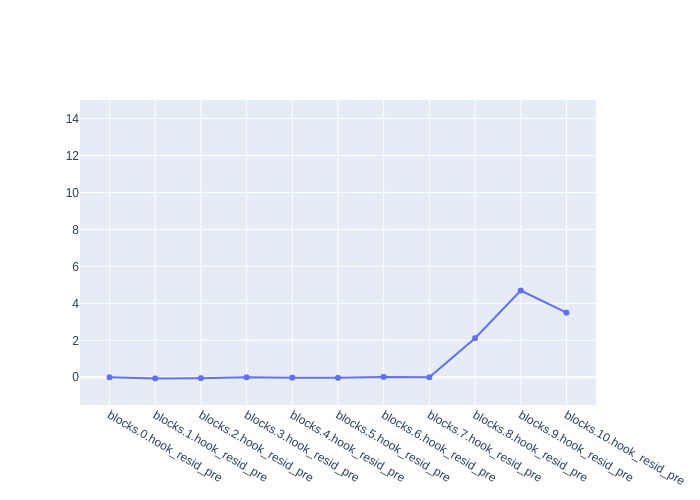

pythia-125m
decoder starts at blocks.9.hook_resid_pre


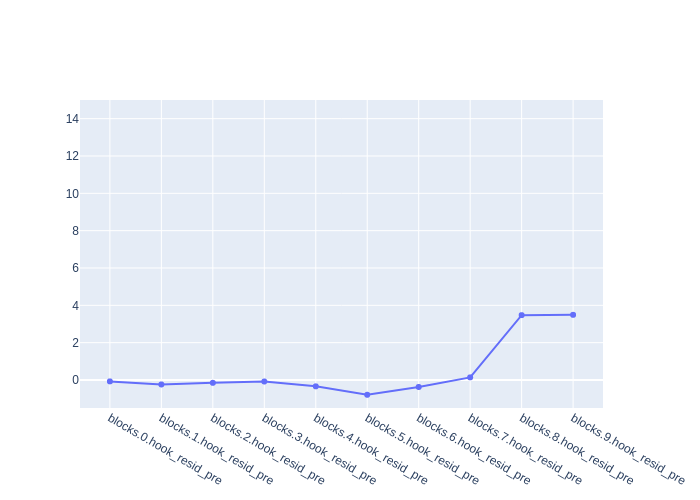

----------------------------------------------------------------------------------------------------


In [17]:
from typing import List, Tuple, Union, Dict, Any, Callable, Optional

# from IPython import get_ipython
# ipython = get_ipython()
# # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
# ipython.magic("load_ext autoreload")
# ipython.magic("autoreload 2")
# %reload_ext autoreload

# Note that the corruptions stems from the prompt input being swapped for the answer input.
# Nothing else is corrupted.
# When we patch in, 

model.reset_hooks()

corrupted_prompts = []
for i in range(0, len(prompts), 2):
    corrupted_prompts.append(prompts[i+1])
    corrupted_prompts.append(prompts[i])
corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
corrupted_average_logit_diff = avg_logit_diff_of_last_pos(corrupted_logits, answer_tokens)

print("Clean prompt 0:    ", prompts[0])
print("Corrupted prompt 0:", corrupted_prompts[0])
print("Answer for 0:", answer_pairs[0][0])
print("Clean Average Logit Diff", clean_cache_avg_last_pos_logit_diff)
print("Corrupted Average Logit Diff", corrupted_average_logit_diff)

def patch_activation_of_specific_name_and_pos(
        corrupted_activation: TT["batch", "pos", "d_model"],
        hook,  # hook class object which is an nn.Module
        pos, 
        cache_to_copy_from):
    corrupted_activation[:, pos, :] = cache_to_copy_from[hook.name][:, pos, :]
    return corrupted_activation

def patch_activation_from_name_to_name(
        to_activation: TT["batch", "pos", "d_model"],
        hook,  # hook class object which is an nn.Module, HAS TO BE `hook`!
        from_hook_name,
        cache_to_copy_from):
    to_activation[:, :, :] = cache_to_copy_from[from_hook_name][:, :, :]
    return to_activation

def normalize_patched_logit_diff(
        patched_logit_diff,
        corrupted_average_logit_diff,
        clean_cache_avg_last_pos_logit_diff,):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise. 0 means zero change (the corrupted and patched logits at end of network are the same i.e. the network still wants to output the wrong answer with the same amount of probability), negative means made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_average_logit_diff)/(clean_cache_avg_last_pos_logit_diff - corrupted_average_logit_diff)

def copy_hook_in_run(from_layer, to_layer, model):
    """
    Copy paste hook from `from_layer` to `to_layer` in `cache` and run the rest in `model`.
    """
    # Copy paste hook from `from_layer` to `to_layer` in `cache`.
    cache[f"hook_{from_layer}"] = cache[f"hook_{to_layer}"]
    # Run the rest in `model`.
    return model.run(**cache)

# cache
"""
 'hook_embed',
 'hook_pos_embed',
 'blocks.0.hook_resid_pre',
 'blocks.0.ln1.hook_scale',
 'blocks.0.ln1.hook_normalized',
  ...,
 'blocks.10.hook_resid_post',
 'blocks.11.hook_resid_pre',
 'blocks.11.ln1.hook_scale',
 'blocks.11.ln1.hook_normalized',
 'blocks.11.attn.hook_q',
 'blocks.11.attn.hook_k',
 'blocks.11.attn.hook_v',
 'blocks.11.attn.hook_attn_scores',
 'blocks.11.attn.hook_pattern',
 'blocks.11.attn.hook_z',
 'blocks.11.hook_attn_out',
 'blocks.11.hook_resid_mid',
 'blocks.11.ln2.hook_scale',
 'blocks.11.ln2.hook_normalized',
 'blocks.11.mlp.hook_pre',
 'blocks.11.mlp.hook_post',
 'blocks.11.hook_mlp_out',
 'blocks.11.hook_resid_post',
 'ln_final.hook_scale',
 'ln_final.hook_normalized'
"""


# [residual_hook_count, n_batches, n_positions, d_model]
last_layer_pre = 12
# accumulated_residual = cache.accumulated_resid(layer=last_layer_pre, incl_mid=False, return_labels=False)

# We want to process
# [n_hooks, n_batches, n_positions]
# value: word outputted once gone through the unembedding when copying forward from `hook` location.
# i.e. argmaxed token index after the unembedding.
# after that we convert to strings.

# We then want to just output [n_hooks, n_positions] and create table for every batch.

# [n_hooks, n_batches, n_positions]


def get_hook_names_to_logit_lens(
    decoder_start_hook_to_overwrite: str = "blocks.11.hook_resid_mid",
    layer_types_to_write_from: List[str] = ["resid_pre", "resid_mid"],# , "resid_post"),
    n_layers_to_consider: int = 12,
    ):
    layer_type_count = len(layer_types_to_write_from)
    hooks_names_to_logit_lens = []
    for layer_i in range(0, n_layers_to_consider * layer_type_count):
        hook_name = utils.get_act_name(layer_types_to_write_from[layer_i%layer_type_count], layer_i//layer_type_count)
        if not hooks_names_to_logit_lens or hooks_names_to_logit_lens[-1] != hook_name:
            hooks_names_to_logit_lens.append(hook_name)
        # Allow hook onto oneself.
        if hook_name == decoder_start_hook_to_overwrite:
            break
    else:
        hooks_names_to_logit_lens.append(decoder_start_hook_to_overwrite)
    return hooks_names_to_logit_lens

from transformer_utils.logit_lens.plotting import _plot_logit_lens
from transformer_utils.logit_lens.plotting import postprocess_logits

def plot_model_larger_unembedding(
    model,
    cache,
    decoder_start_hook_to_overwrite: str,# = "blocks.11.hook_resid_mid",
    layer_types_to_write_from: Tuple[str, ...],# = ("resid_pre", "resid_mid"),# , "resid_post"),
    n_layers_to_consider: int,# = 12,
    prompt_tokens,
    answer_tokens,
    plot_logit_difference=False,
    probs=False,
    ranks=True,
    kl=False,
    top_down=False,
    ):
    hooks_names_to_logit_lens = get_hook_names_to_logit_lens(
        decoder_start_hook_to_overwrite=decoder_start_hook_to_overwrite,
        layer_types_to_write_from=layer_types_to_write_from,
        n_layers_to_consider=n_layers_to_consider,
    )
    n_hooks = len(hooks_names_to_logit_lens)
    n_batches = prompt_tokens.shape[0]
    n_positions = prompt_tokens.shape[1]
    d_vocab = model.cfg.d_vocab

    patched_hook_batch_position_to_token = torch.zeros(
        n_hooks,
        n_batches,
        n_positions,
        device="cuda", 
        dtype=torch.long,
    )
    #[n_hooks, n_batches, n_positions, d_vocab]
    patch_logit_all = torch.zeros(
        n_hooks,
        n_batches,
        n_positions,
        d_vocab,
        device="cuda",
        dtype=torch.float32,
    )
    for hook_index, hook_name in enumerate(hooks_names_to_logit_lens):
        hook_fn = partial(
            patch_activation_from_name_to_name, 
            from_hook_name=hook_name, 
            cache_to_copy_from=cache
        )
        # Run everything as normal except force the activation at specified locations to
        # be of the one that we introduce.
        # [n_batches, n_positions, d_vocab]
        patched_logits = model.run_with_hooks(
            prompt_tokens, 
            # get `resid_pre` hook of layer (e.g. `blocks.1.hook_resid_pre`) and replace them with our hook.
            # fwd_hooks = [(utils.get_act_name("resid_pre", 11), hook_fn)], 
            fwd_hooks = [(decoder_start_hook_to_overwrite, hook_fn)], 
            return_type="logits")
        
        patch_logit_all[hook_index] = patched_logits

        # [n_batches, n_positions]
        patched_hook_batch_position_to_token[hook_index] = patched_logits.argmax(dim=-1)

    #[n_batches, n_hooks, n_positions] ->str
    logit_lens_of_prompts = []
    for batch in range(n_batches):
        logit_lens_of_prompts.append([])
        for hook_index in range(n_hooks):
            logit_lens_of_prompts[-1].append(model.to_str_tokens(patched_hook_batch_position_to_token[hook_index, batch]))

    # [n_batches, n_positions] -> str
    string_of_token_at_batch_pos= []
    for tokens in prompt_tokens:
        string_of_token_at_batch_pos.append(model.to_str_tokens(tokens))

    # [n_hooks] -> str
    # hook_names = [utils.get_act_name("resid_pre", layer//2) if not(layer%2) else utils.get_act_name("resid_mid", layer//2) for layer in range(last_layer_pre*2)]

    # px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

    # px.imshow(logit_lens_of_prompts[0], color_continuous_midpoint=0.0, color_continuous_scale="RdBu", x=string_of_token_at_batch_pos[0], y=hook_names).show(None)


    # # Get the average logit difference.
    # patched_logit_diff = avg_logit_diff_of_last_pos(patched_logits, answer_tokens)
    # patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(
    #     patched_logit_diff,
    #     corrupted_average_logit_diff,
    #     clean_cache_avg_last_pos_logit_diff,
    # )
    prompt_index = 0
    prompt_position_labels = [f"{tok}_{i}" for i, tok in enumerate(string_of_token_at_batch_pos[prompt_index])]

    # print(avg_logit_diff_of_last_pos(patch_logit_all[-1], answer_tokens).cpu())
    print(model.cfg.model_name)
    print("decoder starts at", decoder_start_hook_to_overwrite)
    if plot_logit_difference:
        averages = []
        for i in range(n_hooks):
            averages.append(avg_logit_diff_of_last_pos(patch_logit_all[i], answer_tokens).cpu())
            # print(averages[-1])
        
        fig = go.Figure(data=go.Line(x=hooks_names_to_logit_lens, y=utils.to_numpy(averages)))
        fig.update_layout(yaxis_range=[-1.5,15])
        fig.show()
    else:
        layer_logits = patch_logit_all[:, prompt_index, :, :].cpu().numpy()
        layer_preds, layer_probs = postprocess_logits(layer_logits)
        _plot_logit_lens(
            # [n_hooks, n_positions, d_vocab]
            layer_logits=layer_logits, 
            # [n_hooks, n_positions]
            layer_preds=layer_preds,
            # [n_hooks, n_positions, d_vocab]
            layer_probs=layer_probs,
            # PreTrainedTokenizer
            tokenizer=model.tokenizer,
            # [1, n_positions]
            input_ids=torch.cat((
                prompt_tokens[prompt_index:prompt_index+1, :], answer_tokens[prompt_index:prompt_index+1, 0:1]), dim=-1),
            start_ix=0,
            layer_names=hooks_names_to_logit_lens,
            model_name=model.cfg.model_name,
            probs=probs,
            ranks=ranks,
            kl=kl,
            top_down=top_down,
        )


import plotly.graph_objects as go

KEEP_MODELS = True
if "models" not in globals() or not KEEP_MODELS:
    models = [
        load_model("gpt2-small"),
        load_model("gpt-neo-125M"),
        load_model("pythia-125m")
    ]
clean_caches_final_logits_caches = []
caches = []
prompt_tokens_list = []
answer_tokens_list = []
for model in models:
    _, prompt_tokens, _, answer_tokens = get_prompt_answer_tokens(model)
    prompt_tokens_list.append(prompt_tokens)
    answer_tokens_list.append(answer_tokens)

    clean_cache_final_logitscaches, cache = model.run_with_cache(prompt_tokens)
    clean_caches_final_logits_caches.append(clean_cache_final_logitscaches)
    caches.append(cache)

# Remember that the top row of the table in the plot corresponds to the full model.
# As we go down the table, we are skipping more and more layers.
# However, the "unembedding" that is being applied to each position remains the same, thus we get our lens.
# Below are the hooks to overwrite i.e. to have the unembedding start from.
decoder_name_list = [
    # "blocks.2.hook_resid_pre",
    "blocks.9.hook_resid_pre",
    "blocks.10.hook_resid_pre",
    "blocks.11.hook_resid_pre",
    "blocks.11.hook_resid_mid", # not available in pythia/gpt-neox
    "blocks.11.hook_resid_post",
]
decoder_name_list.reverse()
layer_types_to_write_from = ["resid_pre", "resid_mid"]# , "resid_post")
n_layers_to_consider = 12 # will stop anyway

# plot_logit_difference = False
probs = True
ranks = False
kl = False
top_down = False

for cache, model, prompt_tokens, answer_tokens in zip(caches, models, prompt_tokens_list, answer_tokens_list):
    for name in decoder_name_list:
        clean_cache_final_logits, cache = model.run_with_cache(prompt_tokens)
        if model.cfg.model_name == "pythia-125m":
            temp = layer_types_to_write_from.copy()
            layer_types_to_write_from = ["resid_pre"]
            if name == "blocks.11.hook_resid_mid":
                continue
        plot_model_larger_unembedding(
            model,
            cache,
            decoder_start_hook_to_overwrite=name,
            layer_types_to_write_from=layer_types_to_write_from,
            n_layers_to_consider=n_layers_to_consider,
            prompt_tokens=prompt_tokens,
            answer_tokens=answer_tokens,
            plot_logit_difference=True,
            probs=probs,
            ranks=ranks,
            kl=kl,
            top_down=top_down,
        )
        if model.cfg.model_name == "pythia-125m":
            layer_types_to_write_from = temp
    print("-" * 100)

# imshow(
#     logit_lens_of_prompts[prompt_index],
#     x=prompt_position_labels,
#     y=hook_names,
#     title="Logit Difference From Patched Residual Stream",
#     labels={"x":"Position", "y":"Layer"},
# )

# imshow(
#     patched_residual_stream_diff,
#     x=prompt_position_labels,
#     title="Logit Difference From Patched Residual Stream",
#     labels={"x":"Position", "y":"Layer"},
# )


gpt2
decoder starts at blocks.11.hook_resid_post


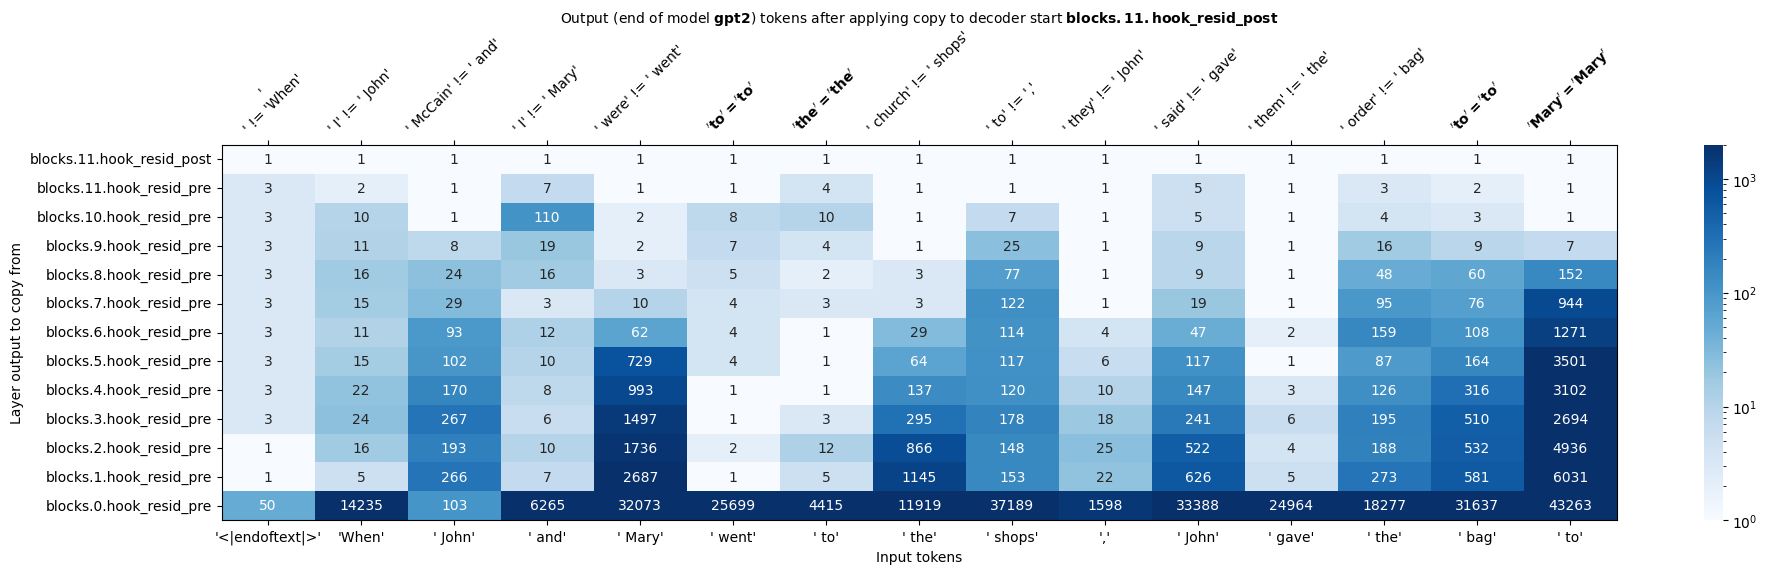

gpt2
decoder starts at blocks.11.hook_resid_mid


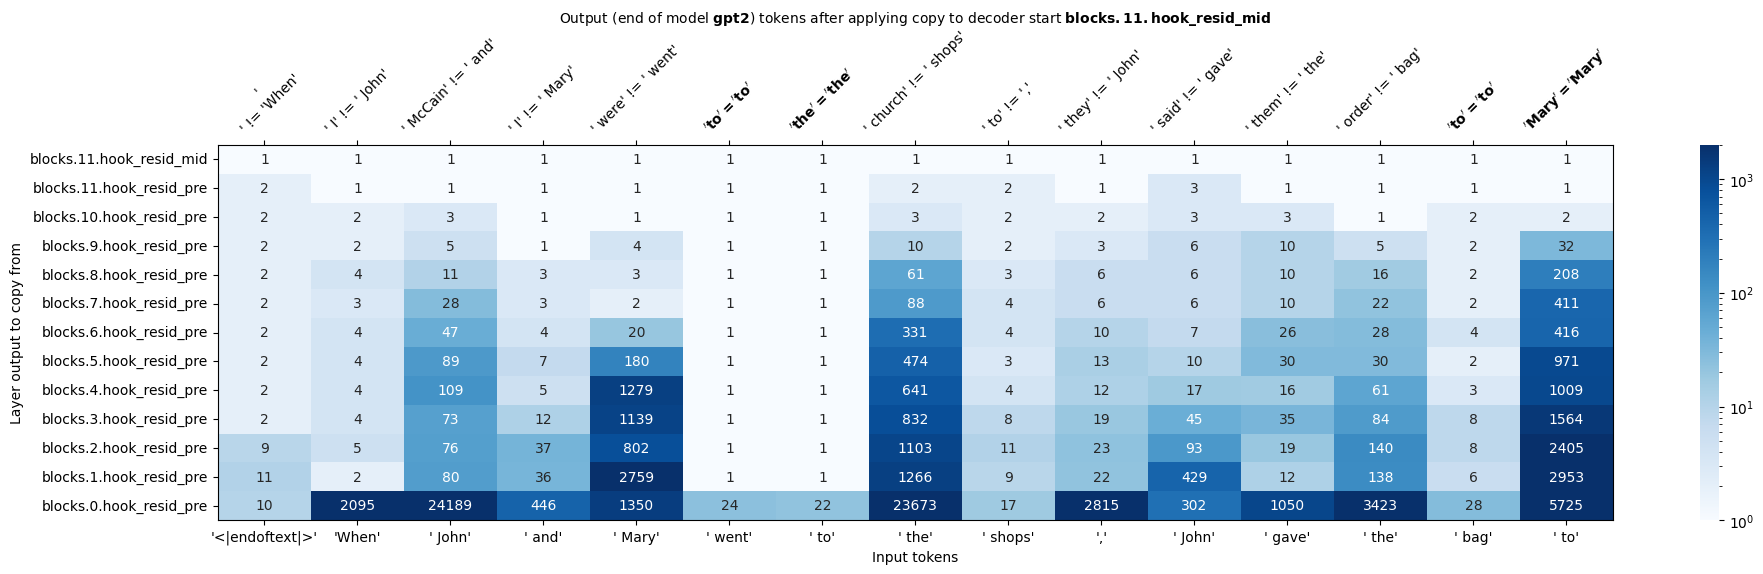

gpt2
decoder starts at blocks.11.hook_resid_pre


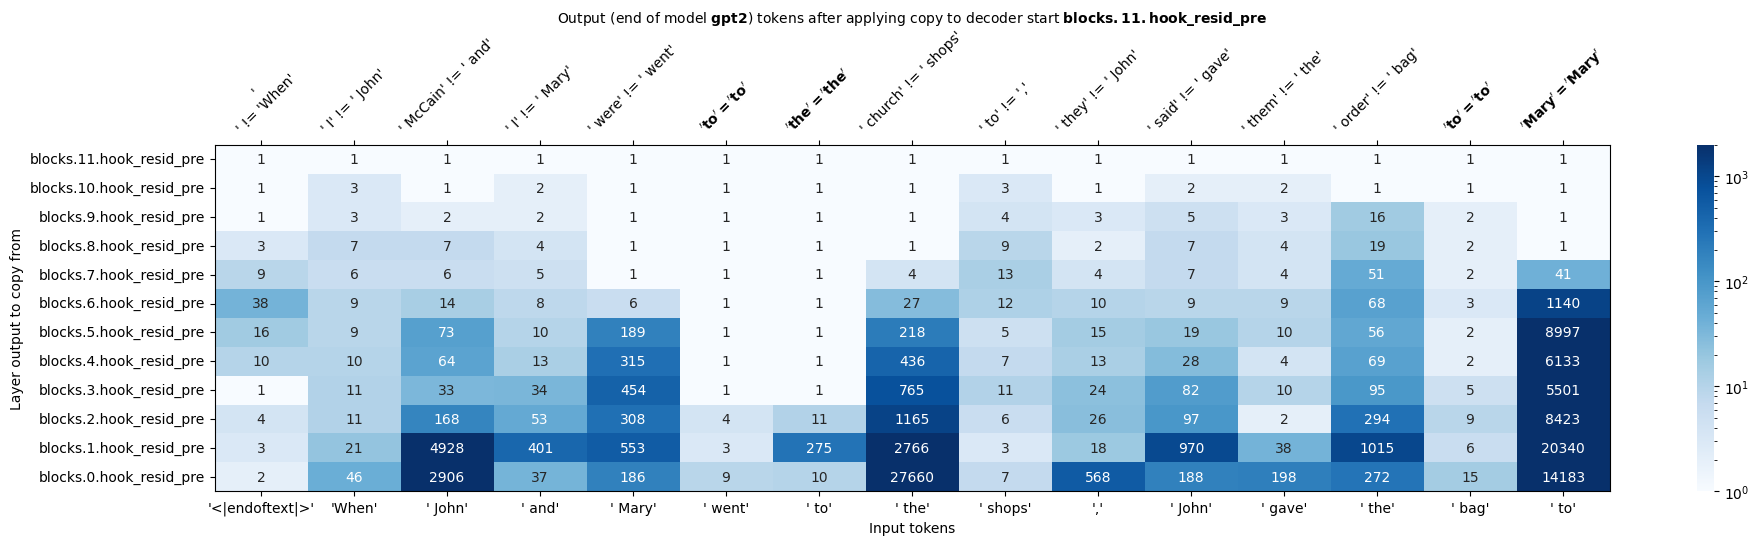

gpt2
decoder starts at blocks.10.hook_resid_pre


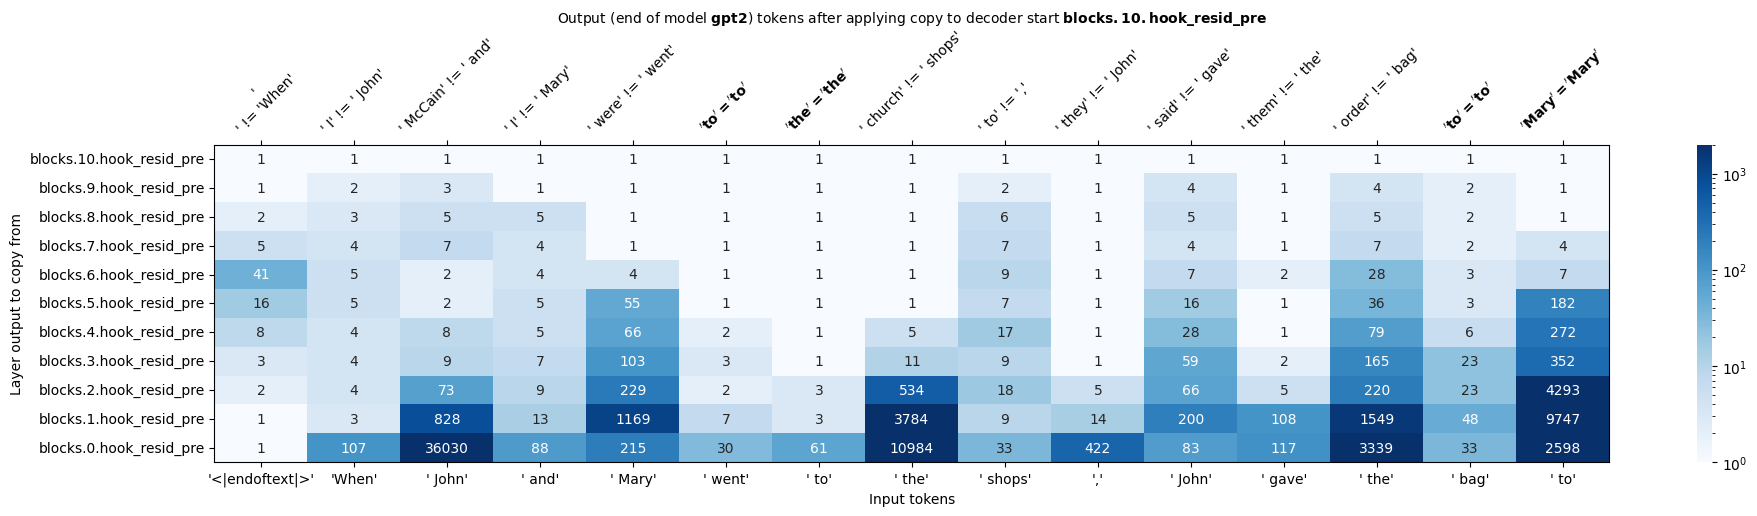

gpt2
decoder starts at blocks.9.hook_resid_pre


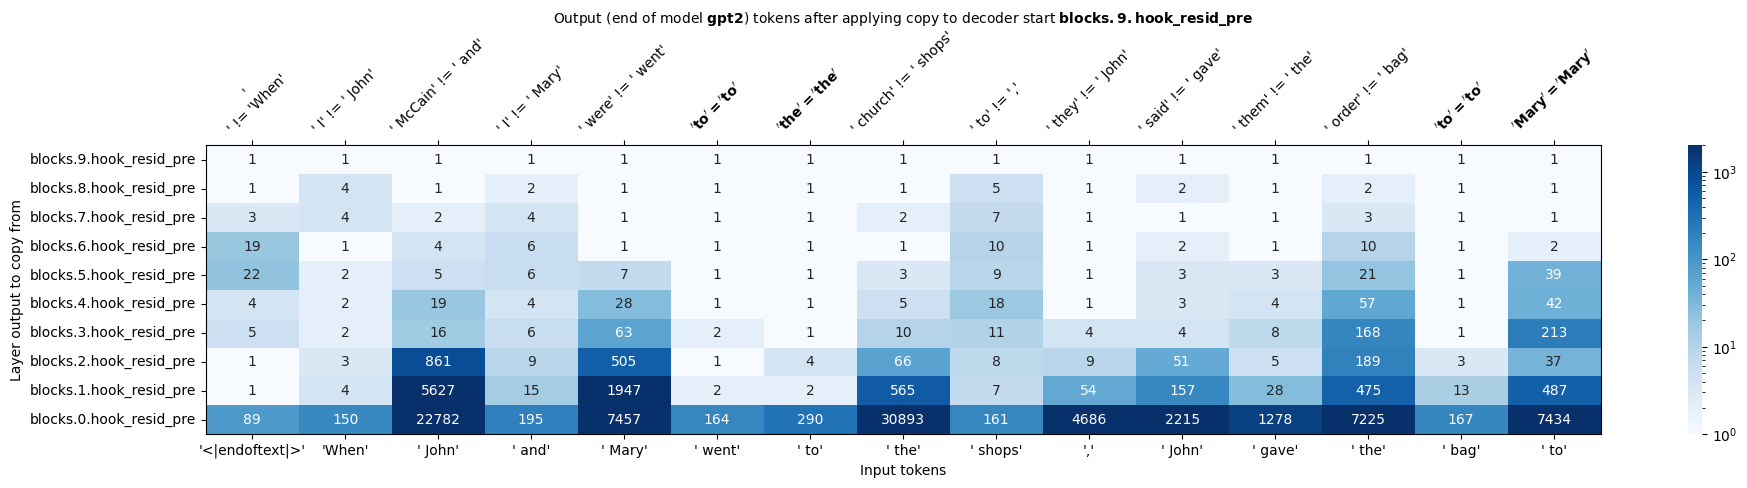

----------------------------------------------------------------------------------------------------
gpt-neo-125M
decoder starts at blocks.11.hook_resid_post


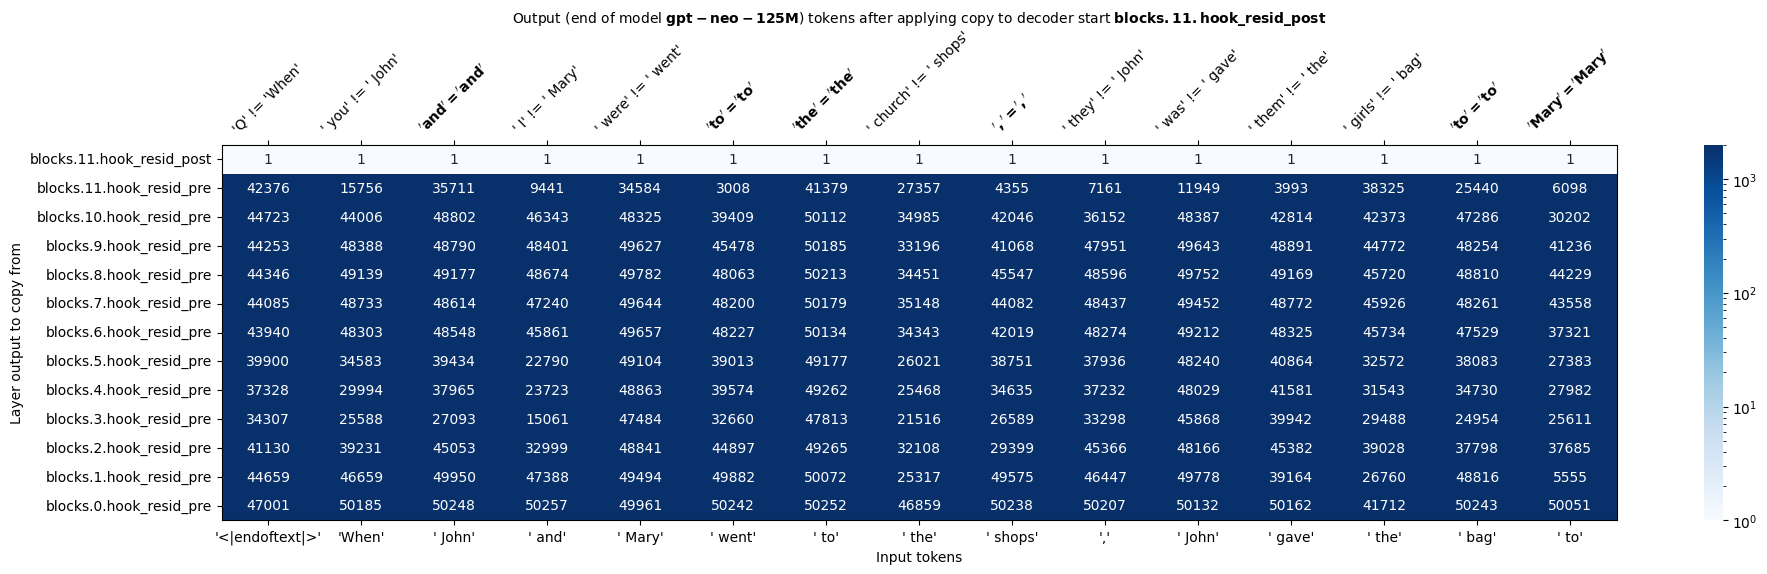

gpt-neo-125M
decoder starts at blocks.11.hook_resid_mid


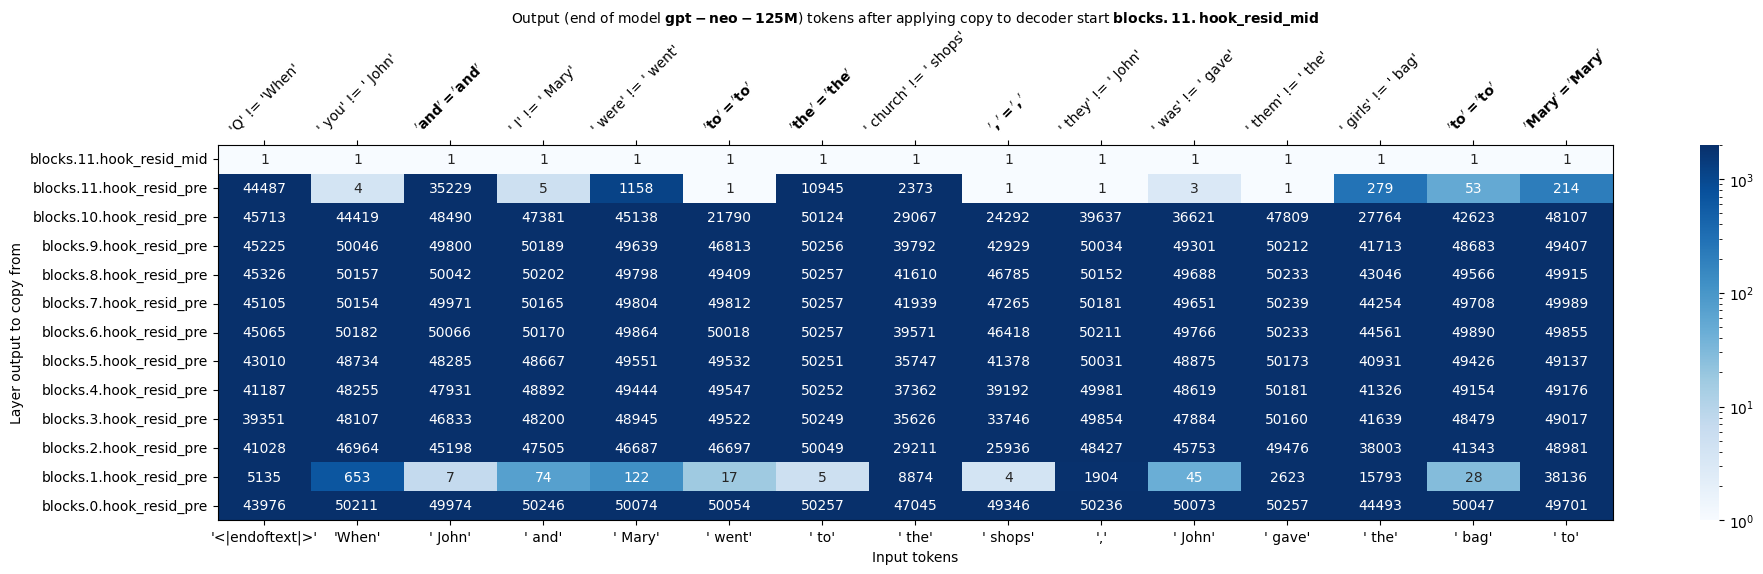

gpt-neo-125M
decoder starts at blocks.11.hook_resid_pre


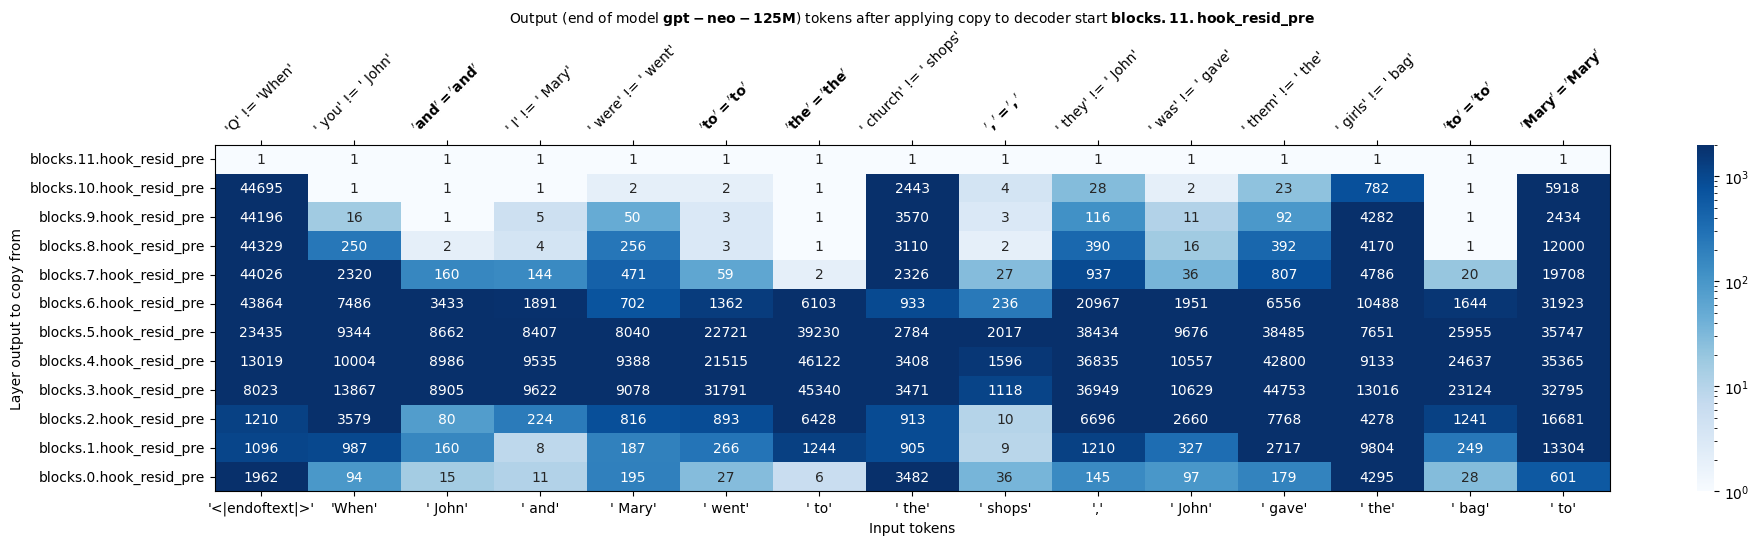

gpt-neo-125M
decoder starts at blocks.10.hook_resid_pre


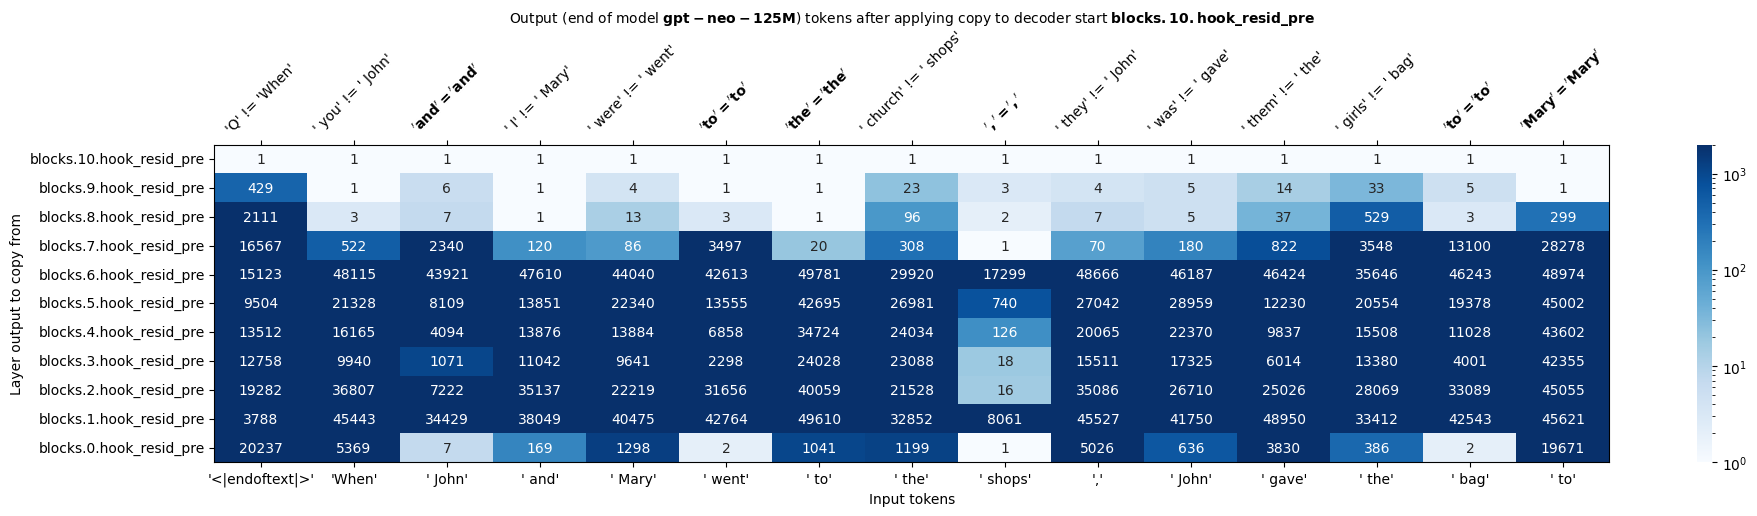

gpt-neo-125M
decoder starts at blocks.9.hook_resid_pre


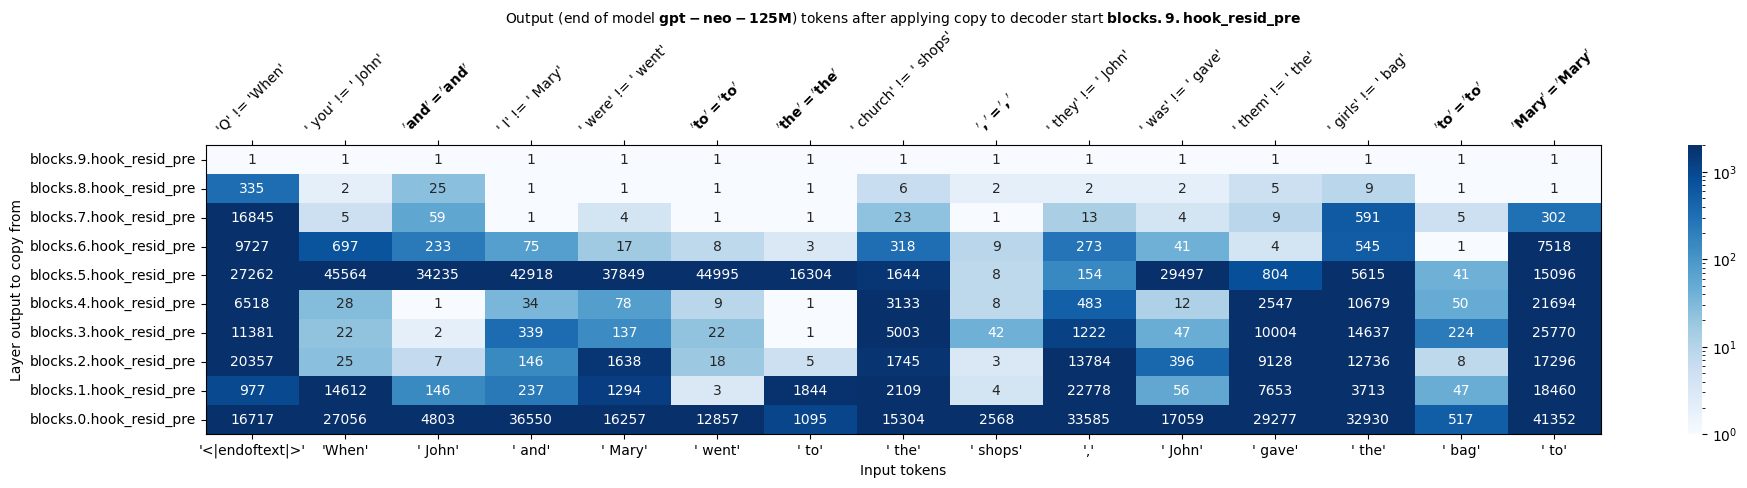

----------------------------------------------------------------------------------------------------
pythia-125m
decoder starts at blocks.11.hook_resid_post


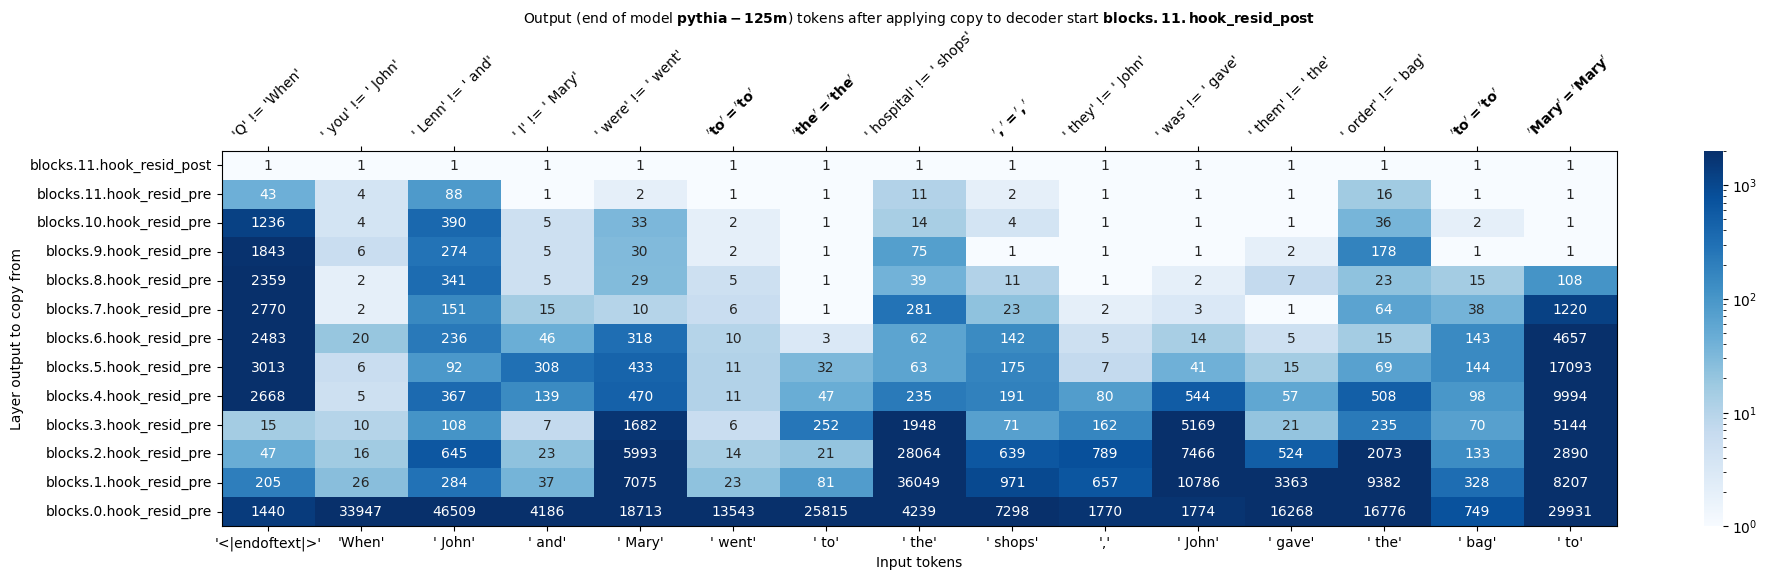

pythia-125m
decoder starts at blocks.11.hook_resid_pre


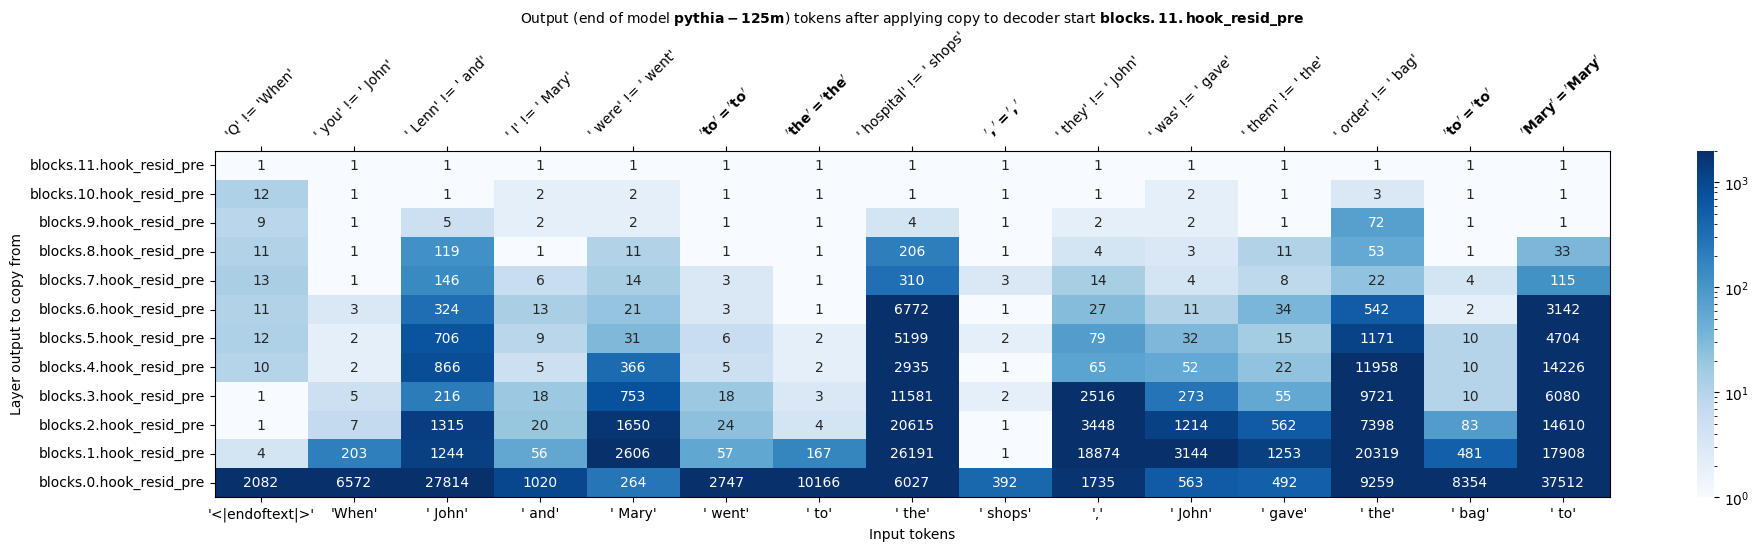

pythia-125m
decoder starts at blocks.10.hook_resid_pre


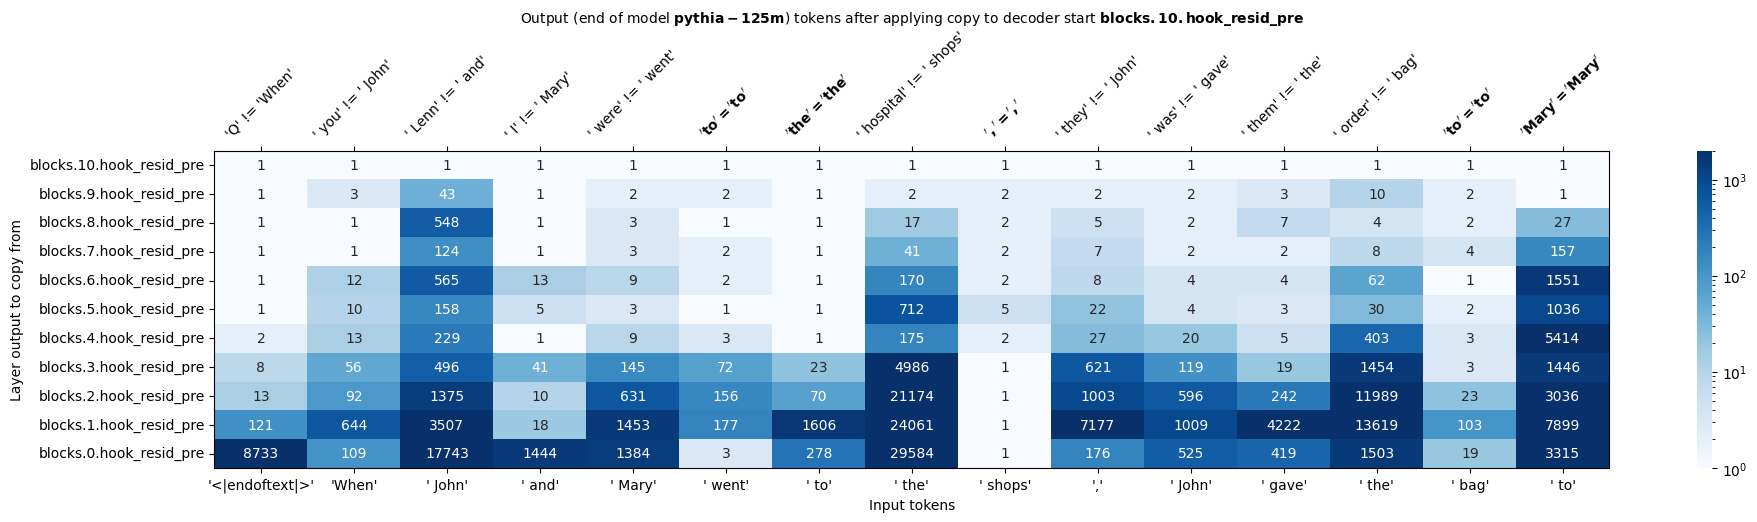

pythia-125m
decoder starts at blocks.9.hook_resid_pre


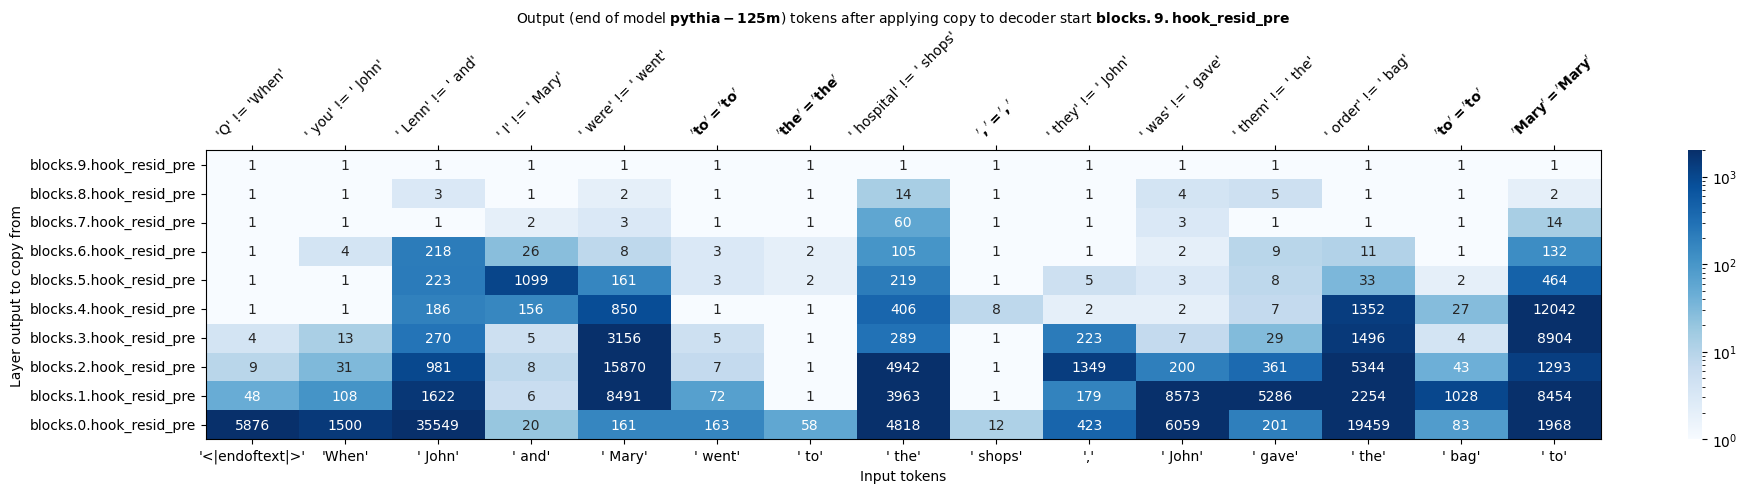

----------------------------------------------------------------------------------------------------


In [18]:
for cache, model, prompt_tokens, answer_tokens in zip(caches, models, prompt_tokens_list, answer_tokens_list):
    for name in decoder_name_list:
        clean_cache_final_logits, cache = model.run_with_cache(prompt_tokens)
        if model.cfg.model_name == "pythia-125m":
            temp = layer_types_to_write_from.copy()
            layer_types_to_write_from = ["resid_pre"]
            if name == "blocks.11.hook_resid_mid":
                continue
        plot_model_larger_unembedding(
            model,
            cache,
            decoder_start_hook_to_overwrite=name,
            layer_types_to_write_from=layer_types_to_write_from,
            n_layers_to_consider=n_layers_to_consider,
            prompt_tokens=prompt_tokens,
            answer_tokens=answer_tokens,
            plot_logit_difference=False,
        )
        if model.cfg.model_name == "pythia-125m":
            layer_types_to_write_from = temp
    print("-" * 100)